
# Part B – Model 2: Deep Learning Sentiment Classifier

This notebook:
- Loads tokenized and padded sequences.
- Builds a deep learning model (LSTM / BiLSTM / GRU / CNN / etc.).
- Trains the model and plots training curves.
- Evaluates performance: F1-score, confusion matrix, ROC & PR curves.
- Saves predictions and probabilities for RL.

You can implement this in PyTorch, TensorFlow/Keras, or another DL library.
Below is a **Keras-based LSTM example skeleton** that you can adapt.


In [ ]:

import os
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import (
    f1_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

DATA_DIR = Path("../data")
PROCESSED_DIR = DATA_DIR / "processed"

print("Processed data directory:", PROCESSED_DIR.resolve())


Processed data directory: C:\Users\Dell\Desktop\Group_2\imdb_sentiment_project\data\processed



## 1. Load Sequences and Labels


In [2]:

X_seq = np.load(PROCESSED_DIR / "X_seq.npy")
labels = np.load(PROCESSED_DIR / "labels.npy")
full_df = pd.read_csv(PROCESSED_DIR / "full_df_clean.csv")

print("Sequence shape:", X_seq.shape)
print("Labels shape:", labels.shape)


Sequence shape: (50000, 200)
Labels shape: (50000,)



## 2. Train/Test Split (Same Strategy as Classical ML)


In [3]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_seq, labels, full_df, test_size=0.25, random_state=42, stratify=labels
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 37500
Test size: 12500



## 3. Build the Deep Learning Model

Example: Bidirectional LSTM.


In [ ]:

MAX_SEQUENCE_LENGTH = X_seq.shape[1]

# You may want to pass the actual vocabulary size from the tokenizer.
# For simplicity, we set a large value here:
VOCAB_SIZE = 20000
EMBEDDING_DIM = 128

model = Sequential([
    Embedding(input_dim=VOCAB_SIZE + 1, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

model.summary()


c:\Users\Dell\miniconda3\envs\tfenv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


## 4. Train the Model and Plot Training Curves


In [5]:

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 204s 827ms/step - accuracy: 0.7641 - loss: 0.4822 - val_accuracy: 0.8376 - val_loss: 0.4166
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 202s 830ms/step - accuracy: 0.8991 - loss: 0.2696 - val_accuracy: 0.8592 - val_loss: 0.3335
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 192s 817ms/step - accuracy: 0.9339 - loss: 0.1862 - val_accuracy: 0.8625 - val_loss: 0.3378
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 209s 846ms/step - accuracy: 0.9480 - loss: 0.1476 - val_accuracy: 0.8597 - val_loss: 0.4482
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 193s 823ms/step - accuracy: 0.9635 - loss: 0.1078 - val_accuracy: 0.8552 - val_loss: 0.4811


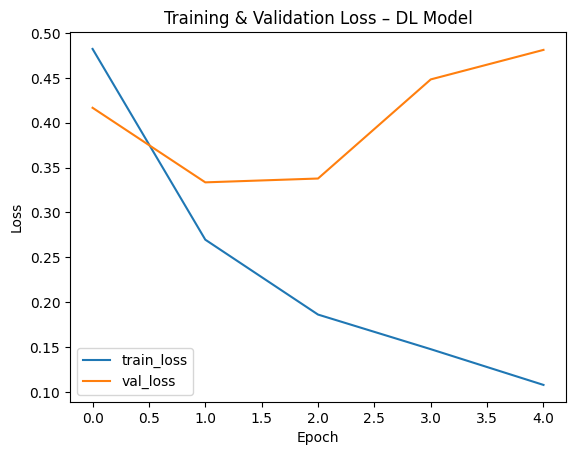

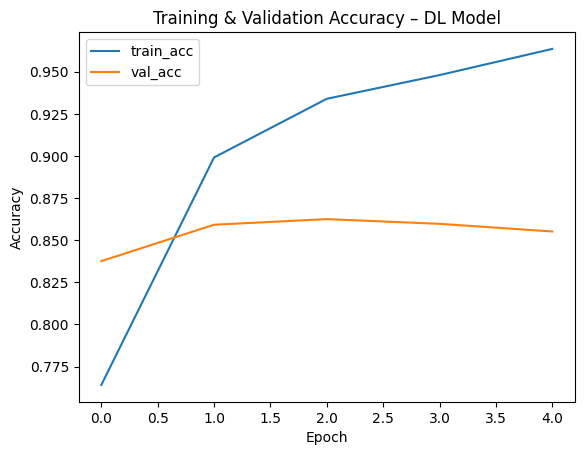

In [6]:

# Plot training curves
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss – DL Model")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy – DL Model")
plt.legend()
plt.show()



## 5. Evaluation: F1, Confusion Matrix, ROC & PR


In [7]:

y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print("F1-score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm


391/391 ━━━━━━━━━━━━━━━━━━━━ 29s 71ms/step
F1-score: 0.8620975646535475
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      6250
           1       0.82      0.91      0.86      6250

    accuracy                           0.85     12500
   macro avg       0.86      0.85      0.85     12500
weighted avg       0.86      0.85      0.85     12500



array([[4954, 1296],
       [ 533, 5717]])

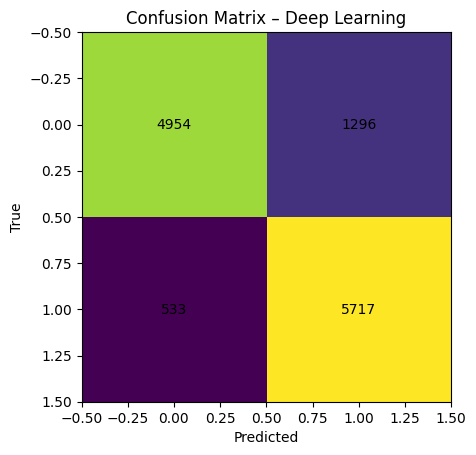

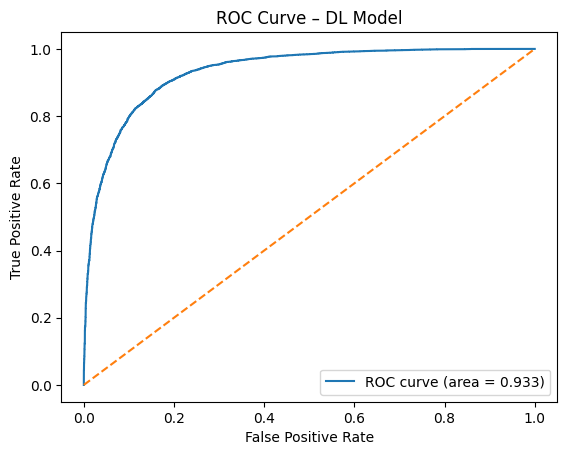

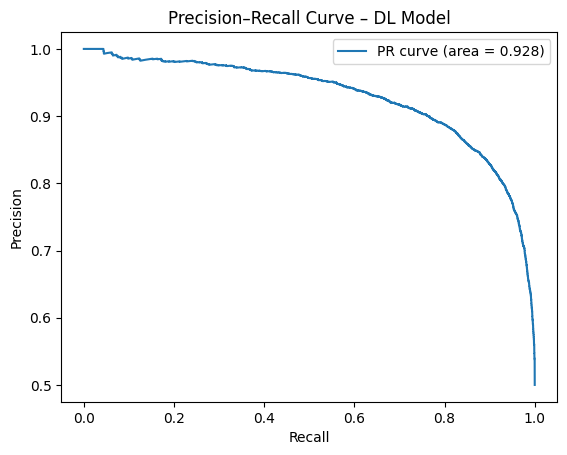

In [8]:

fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_title("Confusion Matrix – Deep Learning")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – DL Model")
plt.legend()
plt.show()

# Precision–Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label=f"PR curve (area = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – DL Model")
plt.legend()
plt.show()



## 6. Misclassified Examples


In [9]:

mis_idx = np.where(y_pred != y_test)[0]
print("Total misclassified:", len(mis_idx))

for i in mis_idx[:5]:
    print("\n--- Misclassified Example ---")
    print("True label:", y_test[i])
    print("Predicted label:", y_pred[i])
    print("Predicted probability (positive):", float(y_proba[i]))
    print("Review:")
    print(df_test.iloc[i]["review"][:700], "...")


Total misclassified: 1829

--- Misclassified Example ---
True label: 0
Predicted label: 1
Predicted probability (positive): 0.7256910800933838
Review:
i have one word: focus.<br /><br />well.<br /><br />IMDb wants me to use at least ten lines of text. okay. let's discuss the fine points of focus. i don't know about the rest of you, but in my first year of film school they taught us a lot of useless crap, like 'you'll all be famous avant-garde filmmakers someday'--but they also taught us how to do this crazy thing called FOCUSING the lens! it was amazing! you give a little twist and wham! everything is clear as a bell. the person who shot what alice found needs to learn a few things about the finer points of focus. lighting, too. this movie is not only completely out of focus, it's also lit like the corner of someone's basement.<br /><br /> ...

--- Misclassified Example ---
True label: 0
Predicted label: 1
Predicted probability (positive): 0.8564841747283936
Review:
I watched this movi


## 7. Save DL Predictions and Probabilities for RL


In [10]:

dl_results = pd.DataFrame({
    "y_true": y_test,
    "y_pred_dl": y_pred,
    "p_dl": y_proba,
    "review": df_test["review"].values,
    "clean_review": df_test.get("clean_review", df_test["review"]).values
})

dl_results.to_csv(PROCESSED_DIR / "dl_results.csv", index=False)
print("Saved DL results to:", PROCESSED_DIR / "dl_results.csv")


Saved DL results to: ..\data\processed\dl_results.csv
